In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import time
import numpy as np
import seaborn as sns
from IPython.display import clear_output, display

In [2]:
class board:
    wMoved = {'l':False,'r':False, 'K':False}
    bMoved = {'l':False,'r':False, 'K':False}
    
    files = ['a','b','c','d','e','f','g','h']
    ranks = [1,2,3,4,5,6,7,8]
    moveDict = {'upx':('up','x'),
               'downx':('down','x'),
               'leftx':('left','x'),
               'rightx':('right','x'),
               'upxleftx':(('up','x'),('left','x'),2),
               'upxrightx':(('up','x'),('right','x'),2),
               'downxleftx':(('down','x'),('left','x'),2),
               'downxrightx':(('down','x'),('right','x'),2),
               'up1':('up',1),
               'down1':('down',1),
               'left1':('left',1),
               'right1':('right',1),
               'up1left1':(('up',1),('left',1),2),
               'up1right1':(('up',1),('right',1),2),
               'down1left1':(('down',1),('left',1),2),
               'down1right1':(('down',1),('right',1),2),
               'up2left':(('up',2),('left',1),2),
               'up2right':(('up',2),('right',1),2),
               'left2up':(('left',2),('up',1),2),
               'left2down':(('left',2),('down',1),2),
               'right2up':(('right',2),('up',1),2),
               'right2down':(('right',2),('down',1),2),
               'down2left':(('down',2),('left',1),2),
               'down2right':(('down',2),('right',1),2),
               'up2':('up',2),
                'down2':('down',2),
               'WpTakeL':(('up',1),('left',1),2),
               'WpTakeR':(('up',1),('right',1),2),
               'BpTakeL':(('down',1),('left',1),2),
               'BpTakeR':(('down',1),('right',1),2),
               'castleR': ('right',2),
               'castleL': ('left',2)}
    
    def __init__(self, read=False, copyFrom=False, copySource=False, imaginary=False):
        #self.calling = []
        #creates a board as a DataFrame or clones an existing board
        if imaginary or copyFrom:
            self.body = copySource.copy()
        else:
            self.body = pd.read_csv(read, index_col=0)
            
    def recon(self, rsquare):
        #self.calling.append('recon')
        #look at a square and return the piece ID or False
        if not rsquare:
            return False
        if rsquare == '0':
            return False
        #print('recon rsquare: ' + str(rsquare))
        file = rsquare[0]
        rank = rsquare[1]
        square = self.body.at[rank,file]
        #print('recon square: ' + str(square))
        return square
    # returns False or wKe1, bQa2, etc...
            
    def walk(self, square, movement):
        #self.calling.append('walk')
        # return new square after given square and move ('up', 1)
        if not square:
            return False
        file = square[0]
        rank = square[1]
        direction = movement[0]
        steps = movement[1]
        if steps == 'x':
            steps = 1
        #print(steps)
        fileCom = {"up":1, "down":-1, "left":-1, "right":1}
        global newPos
        if direction in ["left", "right"]:
            findex = board.files.index(file)
            nindex = findex + (steps * fileCom[direction])
            if nindex not in range(0,8):
                return False
            newFile = board.files[nindex]
            newPos = (newFile, rank)
        if direction in ["up", "down"]:
            newRank = (rank + (steps * fileCom[direction]))
            if newRank not in range(1,9):
                return False
            newPos = (file, newRank)
        return newPos
    
    def movePiece(self, square, newSquare):
        #self.calling.append('movePiece')
        self.body.at[newSquare[1], newSquare[0]] = self.body.at[square[1], square[0]]
        self.body.at[square[1], square[0]] = '0'
    
    def assessSquare(self, square, newSquare, origin):
        #self.calling.append('assessSquare')
        # look at square, new square, and return friend, foe, oob, or empty
        check = self.recon(newSquare)
        if not check:
            #out of bounds
            #print('oob')
            return 'oob'
        elif check == '0':
            #then the square is empty
            #print('empty')
            return 'empty'
        else:
            #the square is either friend or foe
            #print(recon(newSquare))
            #print(recon(square))
            if self.recon(newSquare)[0] is not self.recon(origin)[0]:
                #print('foe')
                return 'foe'
            else:
                #print('friend')
                return 'friend'
    
    def xCheck(self, x, move, square, imaginary=False):
        #self.calling.append('xCheck')
        origin = square
        xSquares = []
        #look through each move str name, make moves and report if possible
        if 'x' in move:
            #print(move + ': x')
            #need to test further moves in this direction until blocked
            blocked = False
            #xSquares = []
            while not blocked:
                #print('not blocked')
                if len(x) == 3:
                    #move is a two-step
                    move1 = x[0]
                    #print(move1)
                    move2 = x[1]
                    #print(move2)
                    newSquare = self.walk(square, move1)
                    #print(newSquare)
                    newSquare = self.walk(newSquare, move2)
                    #print(newSquare)
                else:
                    #move is a one-step
                    newSquare = self.walk(square, x)
                    #print(newSquare)

                result = self.assessSquare(square, newSquare, origin)
                #print(result)
                if result == 'oob':
                    blocked = True
                    newSquare = False
                elif result == 'empty':
                    blocked = False
                    xSquares.append(newSquare)
                    square = newSquare
                elif result == 'friend':
                    blocked = True
                    newSquare = False
                else:
                    blocked = True
                    xSquares.append(newSquare)
                    square = newSquare
            newSquare = xSquares
            if len(newSquare) == 0:
                newSquare = False

        if 'x' not in move:
            #print(move + ': no x')
            #move only specified number of moves

            #non-castle
            if len(x) == 3:
                #print(x)
                #move is a two-step
                #this is where the horses move
                move1 = x[0]
                #print(move1)
                move2 = x[1]
                #print(move2)
                newSquare = self.walk(square, move1)
                newSquare = self.walk(newSquare, move2)
            else:
                #move is a one-step
                newSquare = self.walk(square, x)
            result = self.assessSquare(square, newSquare, origin)
            if result == 'oob':
                newSquare = False
            elif result == 'friend':
                if not imaginary:
                    newSquare = False
            if 'P' in self.recon(square):
                if newSquare:
                    if not imaginary:
                        if newSquare[0] is not square[0]:
                            #if newSquare is in different file
                            if self.recon(newSquare) == '0':
                                #if newSquare is empty
                                newSquare = False
                        elif newSquare[0] is square[0]:
                            #if newSquare is in same file
                            if self.recon(newSquare) != '0':
                                #if newSquare is empty
                                newSquare = False
                    elif imaginary:
                        if newSquare[0] is square[0]:
                            #same file
                            #if self.recon(newSquare) != '0':
                                #not empty
                            newSquare = False
            if newSquare:
                xSquares.append(newSquare)
        return xSquares
    
    def moveTester(self, square, imaginary=False, forCastle=False):
        #self.calling.append('moveTester')
        #returns legal moves of piece in square
        legalmoves = {}
        #print('     moveTester is calling recon')
        if self.recon(square) == '0':
            return False
        #print('     moveTester is calling defaultMoves to check ' + str(square))
        moves = self.defaultMoves(square, forCastle=forCastle)
        #print(moves)
        for move in moves:
            x = board.moveDict[move]
            #print(move)
            #print(x)
            newSquare = self.xCheck(x, move, square, imaginary)
            legalmoves[move] = newSquare

        #returns a dict of moves and their resulting squares (or False)
        return legalmoves
    
    def moveCounter(self, square, imaginary=False):
        #self.calling.append('moveCounter')
        #print('MOVECOUNTER')
        #returns count of legal moves
        count = 0
        #print('    moveCounter is calling moveTester')
        movesReturned = self.moveTester(square, imaginary=imaginary)
        #print('    moveCounter > moveTester returned ' + str(movesReturned))
        #print(movesReturned)
        if movesReturned:
            for move in movesReturned.values():
                if move:
                    count += len(move)
        return count
    
    def myTeam(self, color, imaginary=False):
        #self.calling.append('myTeam')
        #global board
        #print('MYTEAM')
        #team is w or b (str)
        myPieces = {}
        for rank in board.ranks:
            for file in board.files:
                piece = self.body.at[rank,file]
                #print('  myTeam is looking at ' + str(piece))
                #print(piece)
                if color in piece:
                    #print('   myTeam is calling moveCounter')
                    movenum = self.moveCounter((file,rank), imaginary)
                    #print('   myTeam > moveCounter returned ' + str(movenum))
                    myPieces[piece + str(file) + str(rank)] = ((file, rank), movenum)
        return myPieces
    
    def myMoves(self, teamdict):
        #self.calling.append('myMoves')
        #print('MYMOVES')
        moves = {}
        for piece in teamdict:
            x = teamdict[piece]
            if x[1] != 0:
                moves[piece] = x
        return moves
    
    def pickRandomMove(self, team, specific=False, manual=False):
        #self.calling.append('pickRandomMove')
        if not manual:
            canmoves = []
            x = self.myMoves(self.myTeam(team))
            if len(x) == 0:
                return 'done', 'done'
            #print(x)
            while len(canmoves) == 0:
                if specific:
                    pick = specific
                if not specific:
                    pick = random.choice(list(x))
                #print('pick: ' + str(pick))
                square = x[pick][0]
                moves = self.moveTester(square)
                #print(moves)
                for y in list(moves):
                    if moves[y]:
                        canmoves.append(y)
            #print(canmoves)    
            movepick = random.choice(canmoves)
            return pick, movepick
        if manual:
            ok = False
            while not ok:
                wantMove = str(input('enter move here: '))
                square = (wantMove[2], int(wantMove[3]))
                print(square)
                chosenPiece = wantMove[0:4]
                print(chosenPiece)
                chosenDest = (wantMove[8], int(wantMove[9]))
                print(chosenDest)

                choices = game.myTeam(team)

                for myPiece in choices.keys():
                    if chosenPiece == myPiece:
                        square = choices[myPiece]
                        print(myPiece + ': ' +  str(square[1]) + ' moves')
                        moves = game.moveTester(square[0])
                        for move in moves.keys():
                            if len(moves[move]) != 0:
                                if chosenDest in moves[move]:
                                        ok = True

                print(ok)

                if ok:
                    for key in moves.keys():
                        print(key)
                        print(moves[key])
                        if chosenDest in moves[key]:
                            movepick = key
                            pick = chosenPiece
                            return pick, movepick, chosenDest
                else:
                    print('that move does not work, try again')

            
    
    def dangerDetector(self, square, team, imaginary=False, forCastle=False):
        #self.calling.append('dangerDetector')
        attacks = []
        enemy = False
        if team == 'w':
            enemy = 'b'
        if team == 'b':
            enemy = 'w'
        if not enemy:
            return False
        #print('enemy is ' + enemy)
        for rank in board.ranks:
            for file in board.files:
                find = self.recon((file,rank))
                if enemy in find:
                    #print('enemy: ' + str(find) + str(file) + str(rank))
                    #print('        dangerDetector is calling moveTester for imaginary ' + str(imaginary))
                    moves = self.moveTester((file,rank), imaginary=imaginary, forCastle=forCastle)
                    #print(moves)
                    for move in moves.values():
                        if move:
                            #print('square: ' + str(square))
                            #print('move: ' + str(move))
                            if str(square) in str(move):
                                loc = (file,rank)
                                attacks.append(str(self.recon(loc)) + str(file) + str(rank))
        if len(attacks) == 0:
            return False
        return attacks
    
    def canCastle(self, team, side):
        #self.calling.append('canCastle')
        #check for danger or teammate along king path
        dangers = 0
        if team == 'w':
            if board.wMoved[side] or board.wMoved['K']:
                return False
            if side == 'l':
                #king is at ('e',1), rook is at ('a',1)
                #king goes to ('c',1) and left rook goes to ('d',1)
                #e1 thru c1 must not be in danger
                path = [('e',1),('d',1),('c',1)]

            if side == 'r':
                #king is at ('e',1), rook is at ('h',1)
                #king goes to ('g',1) and right rook goes to ('f',1)
                #e1 thru g1 must not be in danger
                path = [('e',1),('f',1),('g',1)]

        if team == 'b':
            if board.bMoved[side] or board.bMoved['K']:
                return False
            if side == 'l':
                #king is at ('e',8), rook is at ('a',8)
                #king goes to ('c',8) and left rook goes to ('d',8)
                #e8 thru c8 must not be in danger
                path = [('e',8),('d',8),('c',8)]

            if side == 'r':
                #king is at ('e',8), rook is at ('h',8)
                #king goes to ('g',8) and rook goes to ('f',8)
                #e8 thru g8 must not be in danger
                path = [('e',8),('f',8),('g',8)]
        for spot in path:
            #print('       canCastle is calling recon')
            piece = self.recon(spot)
            if team + 'K' not in piece:
                if piece == '0':
                    #print('       canCastle is calling dangerDetector')
                    x = self.dangerDetector((spot), team, forCastle=True)
                    if x:
                        dangers += len(x)
                else:
                    dangers += 1
            #print(dangers)
        if dangers == 0:
            return True
        else:
            return False
        
    def castle(self, team, side):
        #self.calling.append('castle')
        #global board
        if team == 'w':
            if side == 'l':
                #king is at ('e',1), rook is at ('a',1)
                #king goes to ('c',1) and left rook goes to ('d',1)
                kingfrom = ('e',1)
                kingto = ('c',1)
                rookfrom = ('a',1)
                rookto = ('d',1)
                return 'white queen side castle'

            if side == 'r':
                #king is at ('e',1), rook is at ('h',1)
                #king goes to ('g',1) and right rook goes to ('f',1)
                kingfrom = ('e',1)
                kingto = ('g',1)
                rookfrom = ('h',1)
                rookto = ('f',1)
                return 'white king side castle'

        if team == 'b':
            if side == 'l':
                #king is at ('e',8), rook is at ('a',8)
                #king goes to ('c',8) and left rook goes to ('d',8)
                kingfrom = ('e',8)
                kingto = ('c',8)
                rookfrom = ('a',8)
                rookto = ('d',8)
                return 'black queen side castle'

            if side == 'r':
                #king is at ('e',8), rook is at ('h',8)
                #king goes to ('g',8) and rook goes to ('f',8)
                kingfrom = ('e',8)
                kingto = ('g',8)
                rookfrom = ('h',8)
                rookto = ('f',8)
                return 'black king side castle'
    
        ### move king ###
        self.movePiece(kingfrom, kingto)
        #################
        ### move rook ###
        self.movePiece(rookfrom, rookto)
        #################
        #return self.body

    def defaultMoves(self, square, forCastle=False):
        #self.calling.append('defaultMoves')
        moves = []
        #print('DEFAULTMOVES')
        #returns default moveset for a piece
        file = square[0]
        rank = square[1]
        #print('      defaultMoves is calling recon')
        piece = self.recon(square)
        if piece == '0':
            return False
        color = piece[0]
        #print(color)
        pieceType = piece[1]
        #print(pieceType)
        if pieceType == 'P':
            #check pawn team and loc
            if color == 'w':
                moves = ['up1','WpTakeL','WpTakeR']
                if rank == 2:
                    #pawn can move up 1 or 2
                    moves = ['up1','up2','WpTakeL','WpTakeR']
            if color == 'b':
                moves = ['down1','BpTakeL','BpTakeR']
                if rank == 7:
                    #pawn can move down 1 or 2
                    moves = ['down1','down2','BpTakeL','BpTakeR']
        if pieceType == 'R':
            moves = ['upx','downx','leftx','rightx']
        if pieceType == 'N':
            moves = ['up2left','up2right','left2up','left2down','right2up','right2down','down2left','down2right']
        if pieceType == 'B':
            moves = ['upxleftx','upxrightx','downxleftx','downxrightx']
        if pieceType == 'Q':
            moves = ['upx','downx','leftx','rightx','upxleftx','upxrightx','downxleftx','downxrightx']
        if pieceType == 'K':
            moves = ['up1','down1','left1','right1','up1left1','up1right1','down1left1','down1right1']
            if not forCastle:
                #print('      defaultMoves is calling canCastle')
                left = self.canCastle(color, 'l')
                right = self.canCastle(color, 'r')
                if left:
                    moves.append('castleL')
                if right:
                    moves.append('castleR')
        return moves
    
    def promote(self, team, square):
        #self.calling.append('promote')
        #global board
        options = ['Q', 'R', 'B', 'N']
        promotion = random.choice(options)
        newPiece = str(team) + promotion
        self.body.at[square[1],square[0]] = newPiece
        return (str(team) + 'P' + str(square[0]) + str(square[1]) + ' promoted to ' + promotion)
        #print(newPiece)
        
    def heatView(self, getSum=False):
        #self.calling.append('heatview')
        #https://stackoverflow.com/questions/63367517/how-to-convert-object-to-int-or-float-in-pandas
        #thanks, dad
        
        #king cannot count towards defending a square that would put it in check
        #pieces cannot count towards defending a square that would put king in check
        claim = board(imaginary=True, copySource=self.body)
        teamB = self.myTeam('b', imaginary=True)
        teamW = self.myTeam('w', imaginary=True)
        #print(teamB.values())

        for file in claim.files:
            for rank in claim.ranks:
                x = self.body.at[rank,file]
                if x != 0:
                    claim.body.at[rank,file] = 0
                    #print(x)
                    if 'w' in x:
                        claim.body.at[rank,file] -= 1
                    if 'b' in x:
                        claim.body.at[rank,file] += 1

        locsB = []
        locsW = []
        targetsB = []
        targetsW = []
        for loc in teamB.values():
                #print(loc[0])
                locsB.append(loc)
        for loc in teamW.values():
                #print(loc[0])
                locsW.append(loc)

        for spot in locsB:
            #use moveTester values as claims
            #print(spot[0])
            #print(square)
            claims = self.moveTester(spot[0], imaginary=True)
            #print(claims)
            #print(claims.values())
            for target in claims.values():
                targetsB += target
        #print(targets)
        #print('targets: ' + str(len(targetsB)))
        for spot in locsW:
            #use moveTester values as claims
            #print(spot[0])
            #print(square)
            claims = self.moveTester(spot[0], imaginary=True)
            #print(claims)
            #print(claims.values())
            for target in claims.values():
                targetsW += target
        #print(targets)
        #print('targets: ' + str(len(targetsW)))

        for b in targetsB:
            #value = game.body.at[x[1], x[0]]
            #print(value)
            claim.body.at[b[1], b[0]] += 1

        for w in targetsW:
            #value = game.body.at[x[1], x[0]]
            #print(value)
            claim.body.at[w[1], w[0]] -= 1

        x = claim.body.copy()
        x = x.apply(pd.to_numeric,errors='ignore')
        if not getSum:
            return sns.heatmap(x, cmap='binary', annot=True)
        else:
            return x.to_numpy().sum()
        
    def TmoveCount(self, turn):
        #self.calling.append('TmoveCount')
        moveBook = self.myTeam(turn)
        moves = 0

        for moveNum in moveBook.values():
            moves += moveNum[1]
        
        return moves
    
    def VirtualMove(self, turn, imaginary=False, manual=False):
        #self.calling.append('VirtualMove')
        totalMoves = game.TmoveCount(turn)
        badMoves = []
        go=True
        while go:
            ### look at team ###
            #print(' looking at team')
            Vgame = board(copySource=self.body, copyFrom=True)
            team = Vgame.myTeam(turn)

            ### pick a random piece and move ###
            
            if not manual:
                #print(' picking random move')
                piece, move = Vgame.pickRandomMove(turn)
                
                #print(' finding possible moves')
                moveDict = Vgame.moveTester((str(piece[2]), int(piece[3])))

                ### this is the place we're gonna move
                #print(' setting destination')
                dest = random.choice(moveDict[move])
                
            if manual:
                piece, move, dest = Vgame.pickRandomMove(turn, manual=manual)
            #moveStr = piece + str(move)
            #print(moveStr)

            if 'P' in piece:
                pawn = True
            else:
                pawn = False

            ### MOVEMENT ################################

            if 'castle' not in move:
                #print(' making a non-castle move')
                ### prepare the start and end positions ###
                square = team[piece][0]
                start = square
                #('d', 3)
                end = dest
                #('d', 4)

                ### detects if 'takes' needs to be said instead of 'to' ###
                #print(' checking if take')
                if Vgame.assessSquare(start, end, start) == 'foe':
                    totake = ' takes '
                    endpiece = str(Vgame.recon(end))
                else:
                    totake = ' to '
                    endpiece = ''
                #print(Vgame.recon(start))
                #print(start)
                #print(end)
                #print(' building statement')
                statement = (str(Vgame.recon(start)) + str(start[0]) + str(start[1]) + str(totake) + str(endpiece) + str(end[0]) + str(end[1]))

                #print(' calling movePiece')
                Vgame.movePiece(start, end)


            ### EXTRAS ####################################

            if 'castle' in move:
                #print(' making castle move')
                if 'L' in move:
                    statement = turn + ' queen side castle'
                    side = 'l'
                if 'R' in move:
                    statement = turn + ' king side castle'
                    side = 'r'
                Vgame.castle(turn, side)

                if team == 'w':
                    Vgame.wMoved[side] = True
                    Vgame.wMoved['K'] = True
                if team == 'b':
                    Vgame.bMoved[side] = True
                    Vgame.bMoved['K'] = True
                start = 'castle'
                end = 'castle'

            if pawn:
                #print(' checking for promotion')
                if turn == 'w':
                    if end[1] == 8:
                        statement = Vgame.promote(turn, end)
                if turn == 'b':
                    if end[1] == 1:
                        statement = Vgame.promote(turn, end)

            ### SAFETY CHECK ##################################

            #print(' calling myTeam')
            team = Vgame.myTeam(turn)

            #print('testing ' + statement)
            #print(' making sure the king is safe')
            for piece in team.keys():
                #print(piece)
                if 'K' in piece:
                    #print('found king')
                    kingDanger = Vgame.dangerDetector(team[piece][0], turn)

            if not kingDanger:
                #print('  king is safe')
                #print(moveStr + ' worked, king is out of danger')
                if not imaginary:
                    self.body = Vgame.body
                    go = False
                    status = True

            if kingDanger:
                #print('  king is not safe')
                #print(moveStr + ' did not work, king in danger')
                if statement not in badMoves:
                    badMoves.append(statement)
                    #print(badMoves)
                    #print(len(badMoves))
                    #print(totalMoves)
                    #print(team)
                if len(badMoves) == totalMoves:
                    go=False
                    status = False
        return status, statement, start, end
    
    def depth(self, history):
        #self.calling.append('depth')
        # record history of every square
        # the history is the value of the square each turn in a long list
        if not history:
            #create blank history
            history = {}
            for file in game.files:
                for rank in game.ranks:
                    x = self.body.at[rank,file]
                    at = str(file)+str(rank)
                    history[at] = [x]
        else:
            for file in game.files:
                for rank in game.ranks:
                    x = self.body.at[rank,file]
                    at = str(file)+str(rank)
                    history[at].append(x)
                    #print(len(history[at]))
                    
        return history

    #def ManualMove(self):
        

In [3]:
game = board("chess board castletest.csv")

# in checktest bQf5 should have 18 moves

In [4]:
history = game.depth(history=False)

Idea: a parallel chess board with values indicating a level of certainty that this team controls the square

In [5]:
game.body

,a,b,c,d,e,f,g,h
8,bR,bN,bB,bQ,bK,bB,bN,bR
7,bP,bP,bP,bP,bP,bP,bP,bP
6,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
2,wP,wP,wP,wP,wP,wP,wP,wP
1,wR,wN,wB,wQ,wK,0,0,wR


<AxesSubplot:>

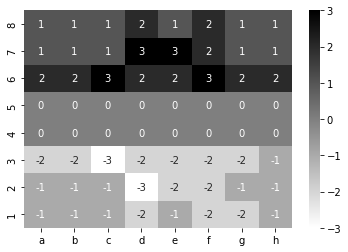

In [6]:
game.heatView()

In [7]:
game.myTeam('b', imaginary=True)

### THESE MOVES ALL BLOCK THE WHITE KING FROM SQUARES ###

{'bPa7': (('a', 7), 1),
 'bPb7': (('b', 7), 2),
 'bPc7': (('c', 7), 2),
 'bPd7': (('d', 7), 2),
 'bPe7': (('e', 7), 2),
 'bPf7': (('f', 7), 2),
 'bPg7': (('g', 7), 2),
 'bPh7': (('h', 7), 1),
 'bRa8': (('a', 8), 0),
 'bNb8': (('b', 8), 3),
 'bBc8': (('c', 8), 0),
 'bQd8': (('d', 8), 0),
 'bKe8': (('e', 8), 5),
 'bBf8': (('f', 8), 0),
 'bNg8': (('g', 8), 3),
 'bRh8': (('h', 8), 0)}

In [8]:
def play(steps=False, resetBoard=False, manual=False):
    global turn
    global game
    global Vgame
    global wMoved
    global bMmoved
    global history
    wMoved = {'l':False,'r':False, 'K':False}
    bMoved = {'l':False,'r':False, 'K':False}
    count = 0
    over = False
    if resetBoard:
        game = board("chess board.csv")
        turn = 'w'
    if steps:
        step = 0
    checkmate=False
    history=False
    if manual:
        me = random.choice(['w', 'b'])
        print('you are playing ' + me)
        display(game.body)
    
###### MAIN GAME LOOP ##################################
    
    while True:
        #print('making history')
        history = game.depth(history)
        #print('moving')
        if manual and turn == me:
            status, statement, start, end = game.VirtualMove(turn, manual=manual)   
        else:
            status, statement, start, end = game.VirtualMove(turn, manual=False)
        #print('checking if checkmate')    
        if not status:
            if turn == 'w':
                winner = 'b'
            if turn == 'b':
                winner = 'w'
            print('checkmate after ' + str(step) + ' moves, ' + winner + ' wins!')
            break
                        
            ###check if king is safe before making move permanent
                    
        ### this chunk keeps track of stuff necessary for castling ###
        #print('checking castle stuff')
        if start != 'castle':
            if game.recon(start) == 'wK':
                game.wMoved['K'] = True
            if game.recon(start) == 'bK':
                game.bMoved['K'] = True
            if game.recon(start) == 'wR':
                if start == ('a',1):
                    game.wMoved['l'] = True
                if start == ('h',1):
                    game.wMoved['r'] = True
            if game.recon(start) == 'bR':
                if start == ('a',8):
                    game.bMoved['l'] = True
                if start == ('h',8):
                    game.bMoved['r'] = True

        #print('changing turns')
        q = 0
        if turn == 'b':
            turn = 'w'
            q = 1
        if turn == 'w' and q == 0:
            turn = 'b'
        
        #print('checking for stalemate')
        wPieces = game.myTeam('w')
        bPieces = game.myTeam('b')
            
        #print(board)
        count += 1
        if steps:
            step += 1
            if step == steps:
                return 'paused after ' +  str(step) + ' moves'
        clear_output(wait=True)
        display(game.body)
        
        if len(wPieces) == 1 and len(bPieces) == 1:
            return('stalemate after {} moves'.format(step))
        #print(statement)
        #time.sleep(0.5)
        

In [10]:
play(2000, resetBoard=True, manual=False)

,a,b,c,d,e,f,g,h
8,0,0,0,0,0,0,0,0
7,0,0,0,wN,0,0,bK,0
6,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0
4,0,0,wB,0,wQ,0,0,0
3,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0
1,0,0,0,0,wK,0,0,wR


checkmate after 259 moves, w wins!
